Image Segmentation with Python and Unsupervised Learning
========================================================

![image](butterfly.jpg)

**Import libraries.**

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

**Load image from file and display it.**

In [2]:
img = cv2.imread("butterfly.jpg")
print(type(img))
print(img.shape)
print(img[25,10])

<class 'numpy.ndarray'>
(425, 640, 3)
[10 48 50]


**Display image.**

In [3]:
cv2.imshow("frame",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

**Flatten image, and display in 3-D color space.**

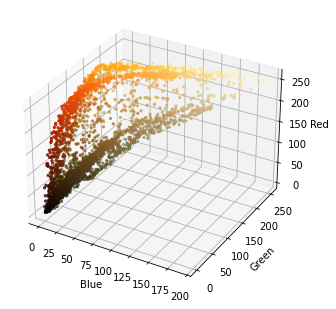

In [4]:
flat = np.reshape(img, (-1,3))
idx = np.random.choice(flat.shape[0], 5000) #array of indices which are randomly chosen rows from a flat array
sampled_flat = flat[idx] #using above array of indices to index the flat array with 5k rows
colors = sampled_flat[:,[2,1,0]] / 255.0 #Adjusting the color data. For matplotlib, taking all the rows in the array, reordering the columns as RGB instead of BGR. And then normalizing the values, because matlplotlib expects the values between 0 and 1.
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(
    sampled_flat[:,0], #B
    sampled_flat[:,1], #G
    sampled_flat[:,2], #R
    c = colors,
    marker = "."
)
ax.set_xlabel("Blue")
ax.set_ylabel("Green")
ax.set_zlabel("Red")
plt.show()
plt.clf()
plt.close()
# Plotted results are for the pixel colors for the butterfly image.
# By adding the 2nd and 3rd line i.e by sampling the indices randomly, we can see that the pixels are not spread out evenly in color space instead there are groupings of them with more important regions of color.

Here, we will be using Unsupervised learning to identify the clusters in this pixel color space.
We call it unsupervised becuase we started out with uncategorized data and look for a pattern to group it by. K-means is an algorithm that does just that. K is for the number of clusters we want to identify and think of means in the sense of average.

**K-means**

In [5]:
K = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 250, 1.0) #Stopping criteria - keep iterating until the cluster centers stop moving but that might take a bit too long with so many pixels. So, setting other criterias for stopping i.e starting with min. accuracy and setting with max. no. of iterations - 250 iterations with 1 pixel accuracy is more than enough.
ssd, bestLabels, centers = cv2.kmeans(
    data = flat.astype(np.float32),
    K = K,
    bestLabels = None,
    criteria = criteria,
    attempts = 10, # Making multiple attempts using different random seeds to see which ones gives best clustering, currently giving 10 attempts
    flags = cv2.KMEANS_RANDOM_CENTERS # To Initialize
    
)
# 3 return values : 
# 1. ssd - sum of square distances, adding up all the distances from the points to their cluster centers to be able to measure how good the clustering is.
# 2. bestlabels - assignments of points to the cluseters which is NONE
# 3. centers - position of centers

**Plotting cluster centers in RGB space**

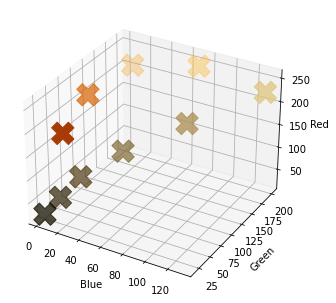

In [6]:
colors = centers[:,[2,1,0]] / 255.0 #Adjusting the color data. For matplotlib, taking all the rows in the array, reordering the columns as RGB instead of BGR. And then normalizing the values, because matlplotlib expects the values between 0 and 1.
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(
    centers[:,0], #B
    centers[:,1], #G
    centers[:,2], #R
    c = colors,
    marker = "X",
    s = 500
)
ax.set_xlabel("Blue")
ax.set_ylabel("Green")
ax.set_zlabel("Red")
plt.show()
plt.clf()
plt.close()

**Plot segmented image**

In [7]:
centers = centers.astype(np.uint8)
print(centers)
print(bestLabels)
segmented_flat = centers[bestLabels]
segmented_image = segmented_flat.reshape(img.shape)

cv2.imshow("frame", segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
#As only 5 colors is being used, since we only looked for 5 clusters.

[[ 82 143 171]
 [ 42  98 121]
 [  2  19  22]
 [130 200 224]
 [  7 103 216]
 [ 73 191 251]
 [ 24 162 245]
 [ 18  60  81]
 [  9  38  48]
 [  3  58 167]]
[[8]
 [8]
 [8]
 ...
 [2]
 [2]
 [2]]


**Elbow method**

Here, establishing an objective criterion for determining the best value of K. We call K as the number of clusters that we chose to look for. The best clustering is one of the distances between the points and the clusters centers are minimized. That means clusters should be as compact as possible. So, maybe the value of K must be selected that gives the compact clusters. But, here we run into a problem. As we keep making K larger, the distances will keep getting smaller. In the limit, imagine one could have one cluster center for each pixel and then all the distances could be 0. So, we need to use a different method and here we'll use the Elbow method.

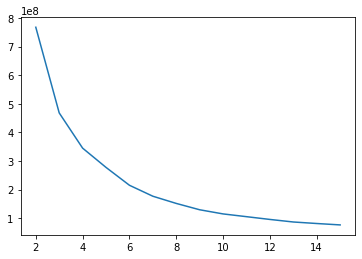

In [8]:
Ks = []
distances = []

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 250, 1.0) #Stopping criteria - keep iterating until the cluster centers stop moving but that might take a bit too long with so many pixels. So, setting other criterias for stopping i.e starting with min. accuracy and setting with max. no. of iterations - 250 iterations with 1 pixel accuracy is more than enough.

for K in range(2,16):
    ssd, bestLabels, centers = cv2.kmeans(
        data = flat.astype(np.float32),
        K = K,
        bestLabels = None,
        criteria = criteria,
        attempts = 10, # Making multiple attempts using different random seeds to see which ones gives best clustering, currently giving 10 attempts
        flags = cv2.KMEANS_RANDOM_CENTERS # To Initialize
    
    )
    Ks.append(K)
    distances.append(ssd)
plt.plot(Ks, distances)
plt.show()

So what we see is that as we increase K, the sum of squared distances drops off very quickly and then it levels off. There's like a point of diminishing returns. The elbow method is named after this shape here and the idea is to visually inspect this plot and decide that It's really not worth increasing K past eight.  